Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'2.0.0-beta1'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Build a lines segmentation model based on unet architecture 

Here is [the paper](https://arxiv.org/pdf/1505.04597.pdf)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [4]:
from recognizer.datasets import Dataset
from recognizer.networks import unet
from recognizer.networks import unet_mini
from recognizer.networks import fcn
from recognizer.networks import NetworkInput

In [5]:
lines_detector_path = Dataset.processed_data_path()/"lines_detector"

lines_detector_train_images_path = lines_detector_path/"train"/"images"
lines_detector_train_masks_path = lines_detector_path/"train"/"masks"

lines_detector_valid_images_path = lines_detector_path/"valid"/"images"
lines_detector_valid_masks_path = lines_detector_path/"valid"/"masks"

lines_detector_test_images_path = lines_detector_path/"test"/"images"
lines_detector_test_masks_path = lines_detector_path/"test"/"masks"

Hyperparameters

In [6]:
batch_size = 16
epochs = 5

number_of_classes = 2

In [7]:
model_save_path = Path("../recognizer/weights/lines_detector.h5")

## Load dataset

In [8]:
def load_images_and_masks_in_path(images_path: Path, masks_path: Path):
    x = []
    y = []

    sorted_image_names = sorted(images_path.glob("*.png"))
    sorted_mask_names = sorted(masks_path.glob("*.png"))
    for image_file_name, mask_file_name in tqdm(zip(sorted_image_names, sorted_mask_names)):
        image = img_to_array(Image.open(image_file_name))
        mask = img_to_array(Image.open(mask_file_name), dtype=np.uint8)

        x.append(image)
        y.append(mask)
        
    return np.array(x), np.array(y)

## Augment the dataset

In [9]:
data_gen_args = dict(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_image_datagen = ImageDataGenerator(
    **data_gen_args,
    rescale=1/255
)
test_image_datagen = ImageDataGenerator(rescale=1/255)

mask_datagen = ImageDataGenerator(
    **data_gen_args,
    rescale=1/255
)

Create the generators

In [10]:
def create_generator(image_datagen: ImageDataGenerator, mask_datagen: ImageDataGenerator, x: [Image], y: [Image], seed: int = 1):
    image_generator = image_datagen.flow(
        x,
        batch_size=batch_size,
        seed=seed)
    mask_generator = mask_datagen.flow(
        y,
        batch_size=batch_size,
        seed=seed)

    return zip(image_generator, mask_generator)

In [11]:
train_generator = create_generator(
    train_image_datagen, mask_datagen, 
    *load_images_and_masks_in_path(lines_detector_train_images_path, lines_detector_train_masks_path))
valid_generator = create_generator(
    test_image_datagen, mask_datagen, 
    *load_images_and_masks_in_path(lines_detector_valid_images_path, lines_detector_valid_masks_path))
test_generator = create_generator(
    test_image_datagen, mask_datagen, 
    *load_images_and_masks_in_path(lines_detector_test_images_path, lines_detector_test_masks_path))

986it [00:01, 660.89it/s]
246it [00:00, 746.95it/s]
307it [00:00, 777.02it/s]


Check images and masks transformations

0 :: images shape (16, 256, 256, 1), masks shape (16, 256, 256, 1)


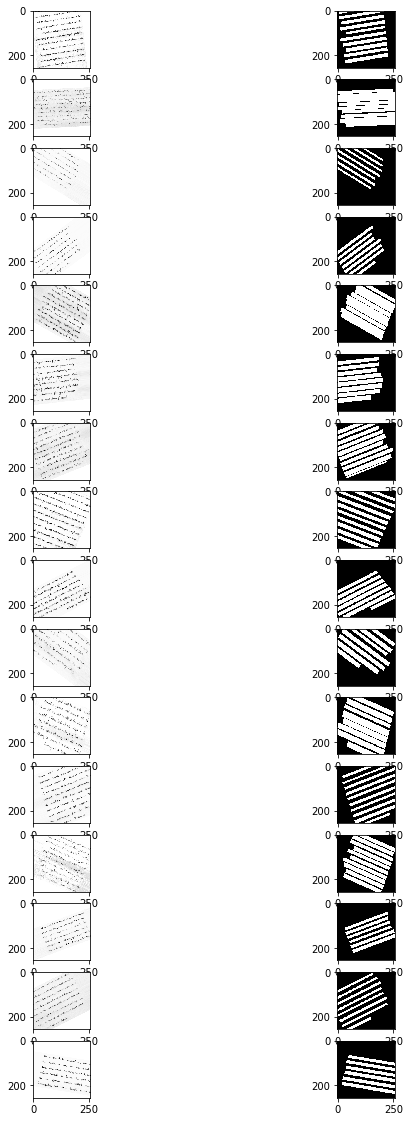

In [12]:
for i, (batch_images, batch_masks) in enumerate(train_generator):
    print(f"{i} :: images shape {batch_images.shape}, masks shape {batch_masks.shape}")
    
    fig = plt.figure(figsize=(10, 20))
    for index, (image, mask) in enumerate(zip(batch_images, batch_masks), 0):
#         print(f">> unique: {np.unique(mask)}")
        mask[mask > .7] = 1
        mask[mask <= .7] = 0
#         print(f"<< unique: {np.unique(mask)}")
        mask = mask.astype(np.uint8)
#         print(f"$$ unique: {np.unique(mask)}")
        
        plt.subplot(batch_size, 2, index * 2 + 1)
        plt.imshow(array_to_img(image), cmap="gray")
        plt.subplot(batch_size, 2, index * 2 + 2)
        plt.imshow(array_to_img(mask), cmap="gray")
        
    plt.show()
    break

### Build an actual generator

Keras `fit_generator` no longer support iterators

In [13]:
train_length = len(lines_detector_train_images_path.ls())
valid_length = len(lines_detector_valid_images_path.ls())
test_length = len(lines_detector_test_images_path.ls())

train_length, valid_length, test_length

(986, 246, 307)

In [14]:
steps_per_epoch = train_length // batch_size
validation_steps = valid_length // batch_size
test_steps = test_length // batch_size

steps_per_epoch, validation_steps, test_steps

(61, 15, 19)

In [15]:
def convert_zip_of_generators_to_lists(generator, steps: int):
    images_list = []
    masks_list = []

    for i, (batch_images, batch_masks) in enumerate(generator):
        for image, mask in zip(batch_images, batch_masks):
            images_list.append(image)
            masks_list.append(mask)

        if i >= steps_per_epoch:
            break
            
    return images_list, masks_list


train_images_list, train_masks_list = convert_zip_of_generators_to_lists(train_generator, steps_per_epoch)
valid_images_list, valid_masks_list = convert_zip_of_generators_to_lists(valid_generator, validation_steps)
test_images_list, test_masks_list = convert_zip_of_generators_to_lists(test_generator, test_steps)

len(train_images_list), len(valid_images_list), len(test_images_list)

(986, 962, 953)

In [16]:
class FormsDataSequence(Sequence):
    
    def __init__(self, images: [Image], masks: [Image], num_classes: int, batch_size=32):
        self.images = images
        self.masks = masks
        self.num_classes = num_classes
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images) // batch_size

    def __getitem__(self, idx):
        """Return a single batch."""
        begin = idx * self.batch_size
        end = min(len(self.images) - 1, (idx + 1) * self.batch_size)
        
        batch_x = []
        batch_y = []
        for index in range(begin, end):
            x = self.images[index]
            batch_x.append(x)

            y = self.masks[index]
            y[np.logical_and(y > .8, y < 1.7)] = 1
            y[y >= 1.7] = 2
            y[y <= .8] = 0
            y = y.astype(np.uint8)
            y = to_categorical(y, self.num_classes).astype(np.int)
            batch_y.append(y)

        return np.array(batch_x), np.array(batch_y)

## Build the model

In [17]:
input_shape = (256, 256, 1)

model = unet_mini(
# model = unet(
# model = fcn(
    NetworkInput(input_shape=input_shape, number_of_classes=number_of_classes)
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

## Train the model

Check progress in TensorBoard by running tensorboard --logdir=logs/lines_detector_model in terminal

In [18]:
# Try removing the old logs first
!rm -r ../logs/lines_detector_model

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_detector_model')
]

In [19]:
model.compile(optimizer=RMSprop(),  #Adam(lr=1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit_generator(
    FormsDataSequence(train_images_list, train_masks_list, number_of_classes, batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_data=FormsDataSequence(valid_images_list, valid_masks_list, number_of_classes, batch_size),
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=callbacks)
history.history.keys()

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
61/61 [==============================] - 36s 583ms/step - loss: 0.7133 - accuracy: 0.6105 - val_loss: 0.6523 - val_accuracy: 0.6411
Epoch 2/5
61/61 [==============================] - 27s 448ms/step - loss: 0.6725 - accuracy: 0.6305 - val_loss: 0.6588 - val_accuracy: 0.6411
Epoch 3/5
61/61 [==============================] - 27s 445ms/step - loss: 0.6037 - accuracy: 0.7252 - val_loss: 0.8113 - val_accuracy: 0.5947
Epoch 4/5
61/61 [==============================] - 27s 447ms/step - loss: 0.3809 - accuracy: 0.8360 - val_loss: 0.8714 - val_accuracy: 0.6072
Epoch 5/5
61/61 [==============================] - 27s 449ms/step - loss: 0.3328 - accuracy: 0.8541 - val_loss: 1.3457 - val_accuracy: 0.6015


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

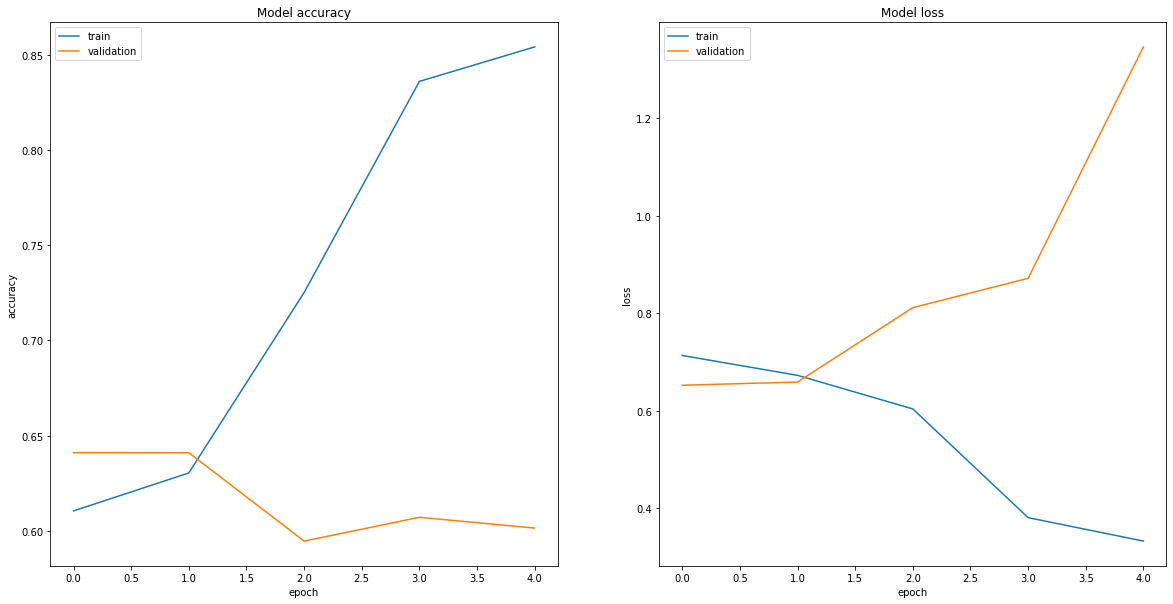

In [21]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [22]:
model.save(model_save_path)

## Restore the model

In [23]:
model = keras.models.load_model(model_save_path)

model.trainable = False
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.trainable_variables

[]

## Predict on one image

(1, 256, 256, 2)

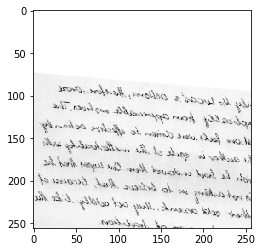

In [24]:
index = 0

image_numpy = train_images_list[index]
plt.imshow(array_to_img(image_numpy), cmap="gray")

test_batch = image_numpy.reshape((1,) + image_numpy.shape)
preds = model.predict(test_batch)
preds.shape

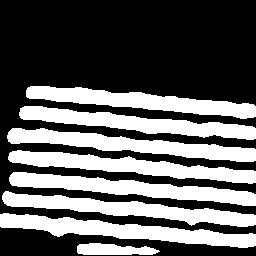

In [25]:
# Merge the 3 channel classes into one for color
pred_image_array = np.expand_dims(np.argmax(preds[0], axis=2), axis=-1)
array_to_img(pred_image_array)

In [26]:
np.min(preds[0]), np.max(preds[0])

(-0.2930321, 116.62061)

In [27]:
np.min(pred_image_array), np.max(pred_image_array)

(0, 1)

In [28]:
np.argmax(preds[0], axis=1).shape

(256, 2)

In [29]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [30]:
np.expand_dims(np.argmax(preds[0], axis=2), axis=-1).shape

(256, 256, 1)

In [31]:
pred_image_array.shape

(256, 256, 1)

Check predication array

In [ ]:
for row in preds[0]:
    if np.max(row) > 0:
        print(row)

[[1.0680561  0.0137336 ]
 [1.7154632  0.07743644]
 [2.261373   0.10842682]
 [2.5976248  0.14715298]
 [2.9192464  0.17018351]
 [3.1238787  0.19885603]
 [3.3144324  0.22302495]
 [3.4411495  0.245932  ]
 [3.556018   0.26567468]
 [3.6267803  0.28207216]
 [3.6793194  0.2936072 ]
 [3.7065837  0.3008736 ]
 [3.7258008  0.3060508 ]
 [3.7348661  0.3091663 ]
 [3.7398906  0.31051493]
 [3.741774   0.31066293]
 [3.742967   0.31034642]
 [3.743082   0.30982065]
 [3.7433288  0.30927202]
 [3.7435293  0.30884582]
 [3.743933   0.3085476 ]
 [3.7440732  0.308356  ]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]
 [3.7442405  0.30824775]


In [ ]:
np.argmax(preds[0], axis=2).shape

In [ ]:
for row in np.argmax(preds[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")

Check target array

In [ ]:
for row in y[0]:
    if np.max(row) > 0:
        print(row)

In [ ]:
np.argmax(y[0], axis=2).shape

In [ ]:
for row in np.argmax(y[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")